<h1 align="center">Volume 1: Facial Recognition.</h1>

    <Tyler Humpherys>
    <Math 345>
    <11/16/21>

In [3]:
import os
import numpy as np
from imageio import imread
from matplotlib import pyplot as plt
import scipy.linalg as la

### Helper Functions

In [4]:
def get_faces(path="./faces94"):
    """Traverse the specified directory to obtain one image per subdirectory. 
    Flatten and convert each image to grayscale.
    
    Parameters:
        path (str): The directory containing the dataset of images.  
    
    Returns:
        ((mn,k) ndarray) An array containing one column vector per
            subdirectory. k is the number of people, and each original
            image is mxn.
    """
    # Traverse the directory and get one image per subdirectory.
    faces = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                # Load the image, convert it to grayscale,
                # and flatten it into a vector.
                faces.append(np.ravel(imread(dirpath+"/"+fname, as_gray=True)))
                break
    # Put all the face vectors column-wise into a matrix.
    return np.transpose(faces)


def sample_faces(k, path="./faces94"):
    """Generate k sample images from the given path.

    Parameters:
        n (int): The number of sample images to obtain. 
        path(str): The directory containing the dataset of images.  
    
    Yields:
        ((mn,) ndarray): An flattend mn-array representing a single
        image. k images are yielded in total.
    """
    files = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                files.append(dirpath+"/"+fname)

    # Get a subset of the image names and yield the images one at a time.
    test_files = np.random.choice(files, k, replace=False)
    for fname in test_files:
        yield np.ravel(imread(fname, as_gray=True))

### Problem 1 

- Implement `show()`.
- Use `show()` to display a face from the `faces94` dataset.

In [5]:
def show(image, m=200, n=180):
    """Plot the flattened grayscale 'image' of width 'w' and height 'h'.
    
    Parameters:
        image ((mn,) ndarray): A flattened image.
        m (int): The original number of rows in the image.
        n (int): The original number of columns in the image.
    """
    #Convert the flattened image into its original shape
    shaped_image = np.reshape(image, (m,n))
    
    #Display image
    plt.imshow(shaped_image, cmap="gray")
    plt.axis("off")
    plt.show()
    

Original Face at index 0:


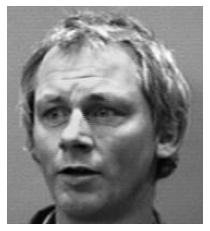

In [6]:
print("Original Face at index 0:")
show(get_faces(path="./faces94")[:,0])

In [7]:
class FacialRec(object):
    """Class for storing a database of face images, with methods for
    matching other faces to the database.
    
    Attributes:
        F ((mn,k) ndarray): The flatten images of the dataset, where
            k is the number of people, and each original image is mxn.
        mu ((mn,) ndarray): The mean of all flatten images.
        Fbar ((mn,k) ndarray): The images shifted by the mean.
        U ((mn,k) ndarray): The U in the compact SVD of Fbar;
            the columns are the eigenfaces.
    """
    # Problems 2-3
    def __init__(self, path='./faces94'):
        """Initialize the F, mu, Fbar, and U attributes.
        This is the main part of the computation.
        """
        #Construct F
        F = get_faces(path=path)
        self.F = F
        
        #Get the shape of F
        m, num_faces = np.shape(F)
                
        #Compute mu
        mu = np.sum(F, axis=1)/num_faces
        
        #Calculate the mean faces
        F_bar = F.copy()
        for i in range(num_faces):
            F_bar[:, i]  = F_bar[:, i] - mu
        
        #Get the SVD
        U, sigma, VH = la.svd(F_bar, full_matrices=False)
        
        #Save the attributes
        self.mean = mu
        self.shifted_face = F_bar
        self.U = U
        
    # Problem 3
    def project(self, A, s):
        """Project a face vector onto the subspace spanned by the first s
        eigenfaces, and represent that projection in terms of those eigenfaces.
        
        Parameters:
            A((mn,) or (mn,l) ndarray): The array to be projected. 
            s(int): the number of eigenfaces.
        Returns: 
            ((s,) ndarray): An array of the projected image of s eigenfaces.
        """
        return self.U[:,:s].T @ A

    # Problem 5
    def find_nearest(self, g, s=38):
        """Find the index j such that the jth column of F is the face that is
        closest to the face image 'g'.
        
        Parameters:
            g ((mn,) ndarray): A flattened face image.
            s (int): the number of eigenfaces to use in the projection.

        Returns:
            (int): the index of the column of F that is the best match to
                   the input face image 'g'.
        """
        #Compute F hat
        F_hat = self.project(self.shifted_face, s)
        
        #Compute G hat
        G_hat = (self.U[:,:s].T @ (g-self.mean)).reshape((-1,1))
        
        #Return the index of the matching face that minimizes the difference of F_hat and G_hat
        return np.argmin(la.norm((F_hat - G_hat), axis=0))

    # Problem 6
    def match(self, image, s=38, m=200, n=180):
        """Display an image along with its closest match from the dataset. 
        
        Parameters:
            image ((mn,) ndarray): A flattened face image.
            s (int): The number of eigenfaces to use in the projection.
            m (int): The original number of rows in the image.
            n (int): The original number of columns in the image.
        """
        #Show the flattened face image
        print("Original Face:")
        show(image, m, n)
        
        #Get the index of the best match
        index = self.find_nearest(image, s)
        
        #Show the index of the best match
        print("Best Match:")
        show(self.F[:, index])

### Problem 2

- In `FacialRec.__init__()`, compute $F$, the mean face $\boldsymbol{\mu}$, and the mean-shifted faces $\bar{F}$.
Store each as an attribute.

- Initialize a `FacialRec` object and display its mean face, plus an original image and its shifted face.

Original Face at index 15:


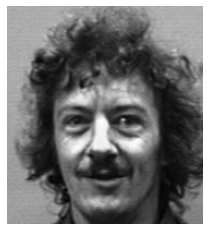

Shifted Face at index 15:


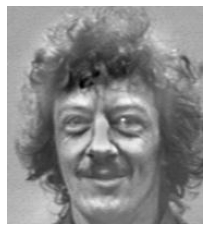

Mean Face of data:


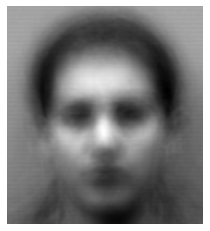

In [8]:
face = FacialRec(path="./faces94")

print("Original Face at index 15:")
show(face.F[:, 15])
print("Shifted Face at index 15:")
show(face.shifted_face[:, 15])
print("Mean Face of data:")
show(face.mean)

### Problem 3

- In `FacialRec.__init__()`, compute the compact SVD of $\bar{F}$ and store the $U$ as an attribute.
- Use `show()` to display some of the eigenfaces (the columns of $U$).
- Implement `FacialRec.project()` (in a single line).


Eigenface at index 10:


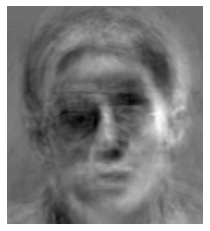

Eigenface at index 15:


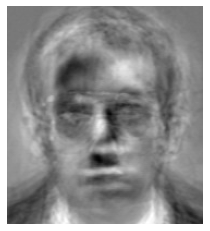

Eigenface at index 35:


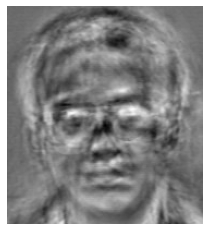

Eigenface at index 60:


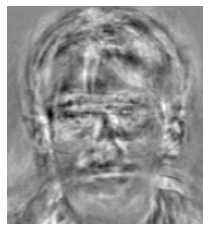

In [9]:
face = FacialRec(path="./faces94")

print("Eigenface at index 10:")
show(face.U[:, 10])

print("Eigenface at index 15:")
show(face.U[:, 15])

print("Eigenface at index 35:")
show(face.U[:, 35])

print("Eigenface at index 60:")
show(face.U[:, 60])

### Problem 4

- Select one of the shifted images $\bar{\mathbf{f}}_i$.
- For at least 4 values of $s$, use `FacialRec.project()` to compute the corresponding $s$-projection $\widehat{\mathbf{f}}_i$, then compute the reconstruction $\widetilde{\mathbf{f}}_i$.
- Display each of the reconstructions and the original image.

Ftilda with 5 singular values:


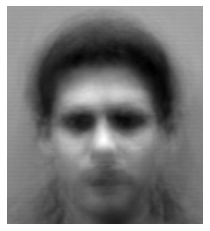

Ftilda with 19 singular values:


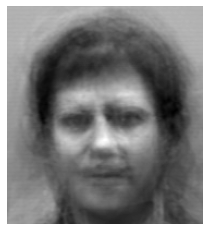

Ftilda with 47 singular values:


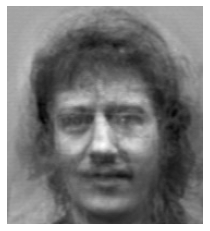

Ftilda with 75 singular values:


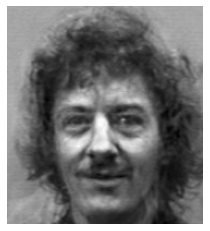

In [10]:
face = FacialRec(path="./faces94")

for s in [5, 19, 47, 75]:
    print(f"Ftilda with {s} singular values:")
    F_tilda = face.U[:,:s] @ face.project((face.shifted_face[:, 15]), s) + face.mean
    show(F_tilda)

### Problem 5 
Implement `FacialRec.find_nearest()`.

### Problem 6

- Implement `FacialRec.match()`.
- Generate some random faces with `sample_faces()`, and use `FacialRec.match()` to find the closest match (let $s=38$).
- For each test, display the sample image and its closest match.

Original Face:


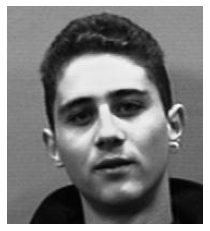

Best Match:


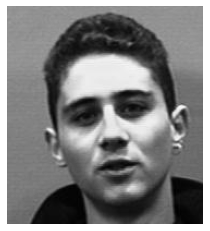

Original Face:


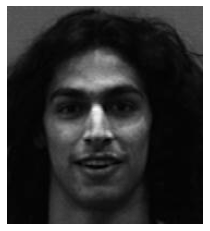

Best Match:


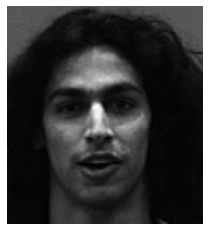

Original Face:


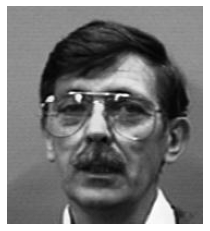

Best Match:


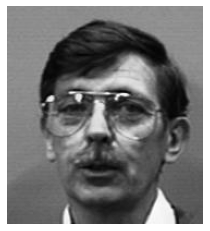

Original Face:


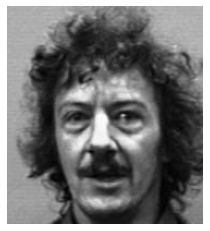

Best Match:


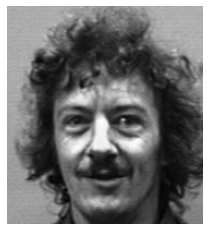

Original Face:


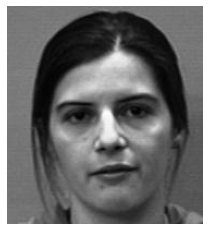

Best Match:


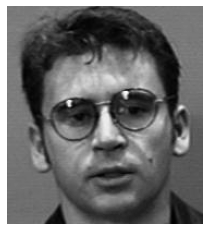

In [11]:
for image in sample_faces(5):
    face.match(image)